In [1]:
from rouge import Rouge
from bert_score import BERTScorer
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate import meteor_score

In [ ]:
import os
import glob

# Function to read the contents of text files
def read_text_file(file_path):
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    #encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252', 'utf-16']
    with open(file_path, 'r', encoding="latin-1") as file:
        
        return file.read().strip()

In [ ]:
# Evaluation of summaries for each model and method
ref_model_gpt4omini = read_text_file('output//Ergebnis_test//2025-07-06_16-50-13_zs_gpt4o_mini.txt') 
model_llama4 = read_text_file('output//Ergebnis_test//2025-07-06_16-05-14_zs_llama4.txt')
model_deepseek = read_text_file('output//Ergebnis_test//2025-07-06_16-05-48_zs_deepseek4.txt')
model_qwen = read_text_file('output//Ergebnis_test//2025-07-06_16-09-54_zs_qwen.txt')
model_gpt41mini = read_text_file('output//Ergebnis_test//2025-07-06_16-45-10_zs_gpt41_mini.txt')

## Reference Based evaluation metrics

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\panla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


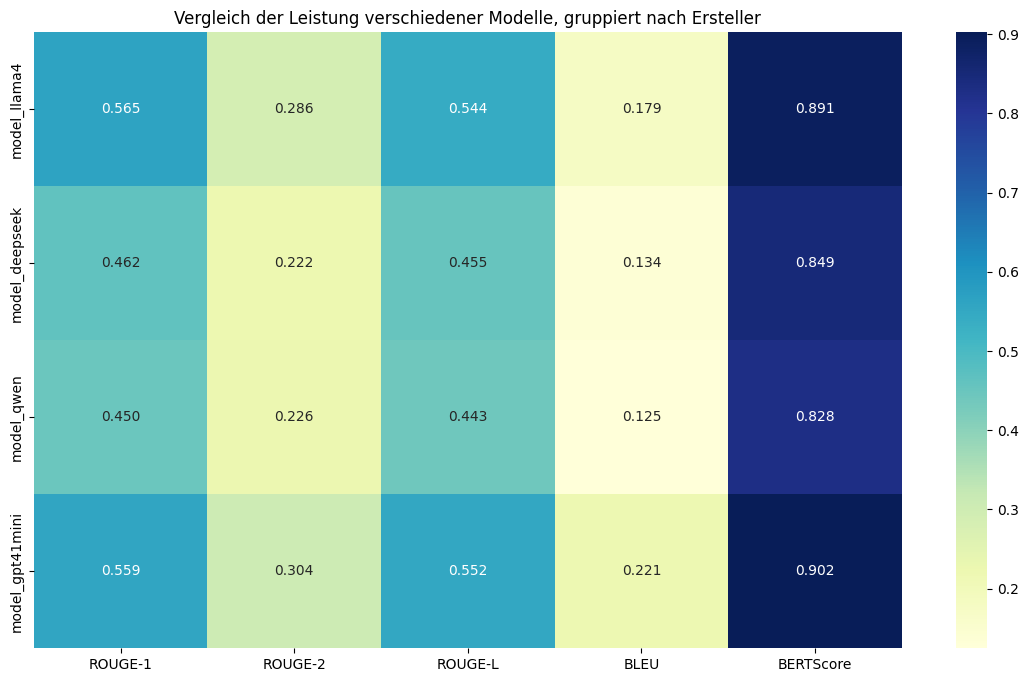

✅ Résultats sauvegardés dans output/Performance_Metrics/Ref_based_eval_metrics.xlsx


In [ ]:
import seaborn as sns

# Download the necessary resources for BLEU
nltk.download('punkt')

# Initialisation of functions for the various metrics
rouge = Rouge()
scorer = BERTScorer(lang="en")
# Function for calculating ROUGE scores
def get_rouge_scores(summary, reference):
    return rouge.get_scores(summary, reference)
# Function for calculating the METEOR score

def get_meteor_score(summary, reference):
    return meteor_score.single_meteor_score(reference, summary)

# Function for calculating the BLEU score
def get_bleu_score(summary, reference):
    reference = [reference.split()]
    summary = summary.split()
    return nltk.translate.bleu_score.sentence_bleu(reference, summary, weights=(0.25, 0.25, 0.25, 0.25))



# Calculation of scores for each summary file
summaries = {
    "model_llama4": model_llama4,
    "model_deepseek":model_deepseek,
    "model_qwen": model_qwen,
    "model_gpt41mini": model_gpt41mini,
    
}

metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "BERTScore"]
results = {metric: [] for metric in metrics}

for summary_name, summary in summaries.items():
    # Calculation of ROUGE scores
    rouge_scores = get_rouge_scores(summary, ref_model_gpt4omini)
    results["ROUGE-1"].append(rouge_scores[0]["rouge-1"]["f"])
    results["ROUGE-2"].append(rouge_scores[0]["rouge-2"]["f"])
    results["ROUGE-L"].append(rouge_scores[0]["rouge-l"]["f"])
    
    
    # Calculation of BLEU scores
    bleu_score = get_bleu_score(summary, ref_model_gpt4omini)
    results["BLEU"].append(bleu_score)
    
    # Calculation of BERTScore
    _, _, f1_score = scorer.score([summary], [ref_model_gpt4omini])
    results["BERTScore"].append(f1_score.mean().item())

# Creation of a DataFrame for the results
results_df = pd.DataFrame(results, index=summaries.keys())

# Style the DataFrame to highlight the two maximum scores per column

def highlight_top4(data):
    color = 'background-color: red'
    df1 = pd.DataFrame('', index=data.index, columns=data.columns)
    for col in data.columns:
        top4 = data[col].nlargest(4).index
        df1.loc[top4, col] = color
    return df1

styled_results_df = results_df.style.apply(highlight_top4, axis=None)

# Display results in table format
#styled_results_df

# New visualisation with heatmap to better represent scores
plt.figure(figsize=(14, 8))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Vergleich der Leistung verschiedener Modelle, gruppiert nach Ersteller")
plt.show()

# Save
os.makedirs('output/Performance_Metrics', exist_ok=True)
output_path = 'output/Performance_Metrics/Ref_based_eval_metrics.xlsx'
styled_results_df.to_excel(output_path, index=False)
print(f"✅ Results saved in {output_path}")